# Цель
Изучить статистические характеристики метода измерения уровня сигнала. Нужно узнать как меняется уровень сигнала с различных сканеров когда все элементы системы (окружение, сканеры и браслет) находятся в неизменном состоянии.

Понимание статистик позволит понять какое количество сигналов с каждого сканера нужно получить, чтобы  вычислить среднее значение с высокой точность. Также это позволит понять насколько высокая точность необходима, чтобы различать сигнал от конкретного сканера при нахождении браслета в разных помещениях. Знаниче этих характеристик позволит спроектировать наиболее эффективный алгоритм определения положения браслета, который будет брать во внимание полученные характеристики.

Таким образом, в рамках этого исследование необходимо:
1.  Собрать сигналы от браслета в разных положениях в каждой комнате. В каждой комнате положения должны выбираться так, чтобы получить наиболее различные сигналы. По 100 сигналов с каждого сканера в каждом положении браслета. При этом в помещении не должно быть движущихся людей и котов, чтобы собрать максимально чистые данные.
2. Для каждого положения вычислить среднее и дисперсию для каждого сканера.
3. Посмотреть как меняется дисперсия в зависимости от среднего значения (насколько дисперсия увеличивается/уменьшается в зависимости от среднего значения уровня сигнала).
4. Посмотреть как среднее по каждому сканеру меняется в зависимости от помещения. Найти минимальную разницу между средними фиксированного сканера из разных помещений. Посмотреть на распределение разниц между положениями из разных помещений.
5. Посчитать какое количество сигналов нужно, чтобы с высокой вероятностью (p=0.05) уловить разницу между средними из двух положений из разных близких комнат.
6. Подобрать параметры фильтра Калмана, которые максимально быстро приближали бы среднее к значению, позволяющему различить два положения из близкикх комнат.

In [65]:
from server import config
from datetime import datetime
import asyncio
from asyncio_mqtt import Client, MqttError
from contextlib import AsyncExitStack
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, metrics, linear_model, multiclass, feature_selection, pipeline
from sklearn.cluster import MeanShift
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pandas as pd
import numpy as np
import seaborn as sbs
from matplotlib import pyplot as plt
import jsons
from server.kalman import KalmanRSSI

## Сбор данных

In [66]:
async def collect_signals(room):
    new_signals = {}
    position = str(datetime.utcnow().timestamp())
    async with Client(
        hostname=config.MQTT_BROKER_URL, port=config.MQTT_BROKER_PORT,
        username=config.MQTT_USERNAME, password=config.MQTT_PASSWORD) as client:
        async with client.unfiltered_messages() as messages:
            await client.subscribe("room_presence/#")
            async for message in messages:
                event = jsons.loads(message.payload.decode())
                if event['id'] != 'eb:cd:02:7f:98:91'.upper():
                    continue

                scanner = message.topic.split('/')[1]
                scanner_signals = new_signals.get(scanner, [])
                scanner_signals.append({'rssi': event['rssi'], 'when': datetime.utcnow()})
                new_signals[scanner] = scanner_signals

                print(dict([(k, len(new_signals[k])) for k in new_signals.keys()]))

                if sum(len(new_signals[k]) >= 8 for k in new_signals.keys()) >= 3:
                    return [
                        {'scanner': s, 'rssi': v['rssi'], 'when': v['when'], 'position': '{}-{}'.format(str(room), str(position)), 'room': room} 
                        for s, values in new_signals.items() for v in values
                    ]

async def collect_and_save_signals(room):
    new_signals = await collect_signals(room)
    df = pd.read_csv('./signals.csv')
    df = pd.concat([df, pd.DataFrame(new_signals)])
    df.to_csv('./signals.csv', index=False)

In [67]:
# await collect_and_save_signals('bedroom')

Во время сбора данных не удалось соблюсти чистоту стерильной комнаты – мимо ходили люди, коты, в некоторых положениях устройство могло сместиться на несколько сантиметров. Для каждого положения сбор данных заканчивался когда количество сигналов с двух сканеров достигало 100 по каждому.

__Предположение__: 100 значений на сканер должно дать приемлемую точность вычисленного среднего сигнала. Нужно в этом убедиться путем анализа распределения в разных положениях, также нужно проверить какой _p_ дает такой объем выборки и какой нужен минимальный объем выборки для приемлемого _p_ чтобы сократить время сбора данных, в каждом положении приходилось ждать от 10 до 20 минут, чтобы собрать 100 сигналов по двум сканерам, это много

## Изучаем статистики

In [68]:
data_df = pd.read_csv('./signals.csv')
data_df['when'] = data_df['when'].astype('datetime64')
room_df = data_df[data_df['room'] == 'guest'].copy()

<AxesSubplot:xlabel='scanner', ylabel='rssi'>

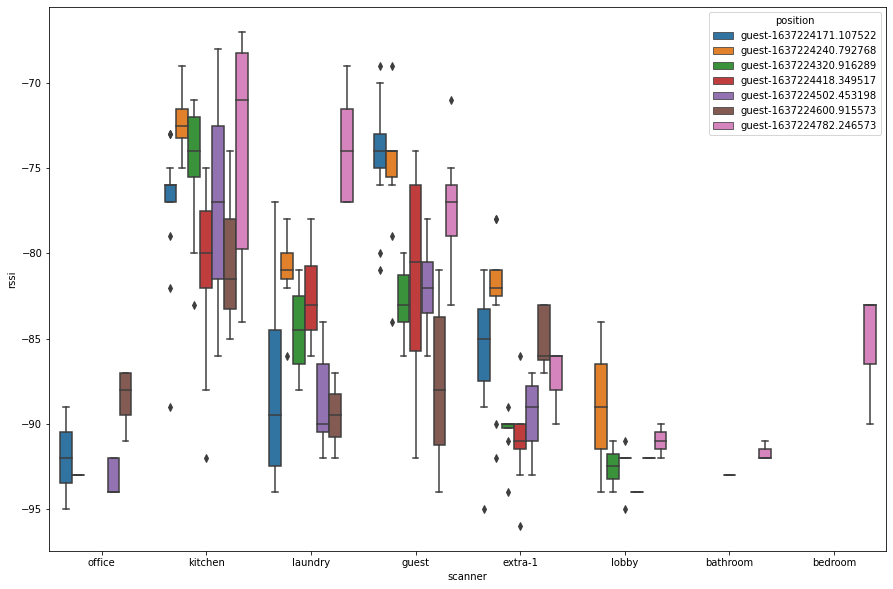

In [69]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
sbs.boxplot(data=room_df, x='scanner', y='rssi', hue='position', ax=ax)

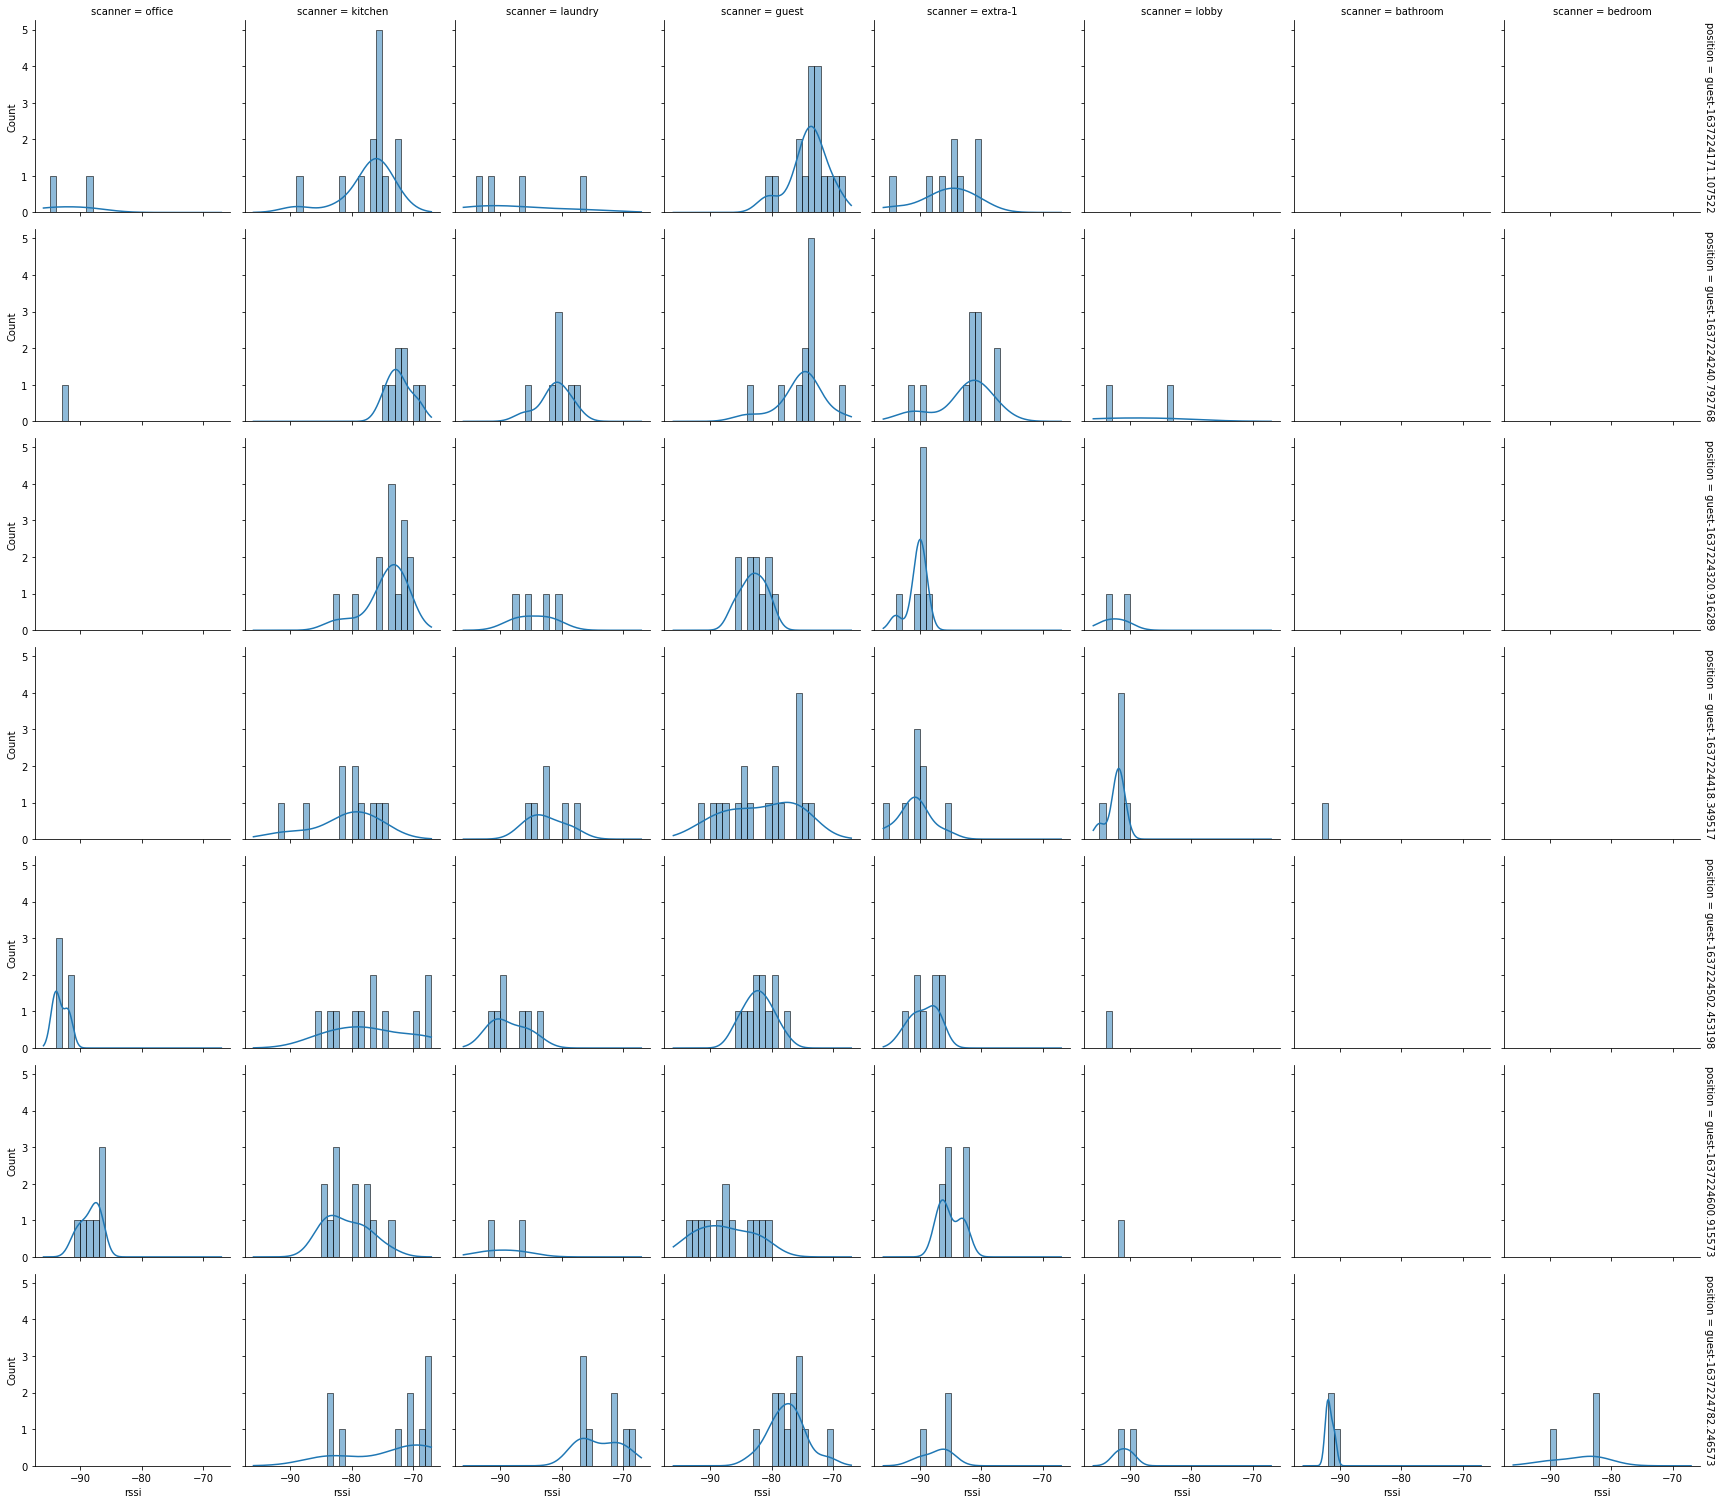

In [70]:
sbs.displot(
    room_df, x="rssi", col="scanner", row="position",
    binwidth=1, height=3, facet_kws=dict(margin_titles=True),
    kind='hist', kde=True,
)

Заметим, что в одном положении сигнал с одного сканера может иметь несколько пиков. Это может говорить о том, что среда каким-то образом изменилась и количество помех увеличилось/уменьшилось, что привело к изменению уровня получаемого со сканера среднего сигнала.

Получим все пики для кадого положения устройства во всех помещениях. Найденные значения - возможные (полученные во время сбора данных) средние  уровня сигнала для каждого помещения.

__Предположение:__ отфильтрованные Калманом значения будут колебаться в приделах этих средних для каждого сканера-помещения.

In [71]:
results_df = []

def get_center_size(data_df, x):
    x = np.round(x)
    return len(data_df[(data_df['rssi'] >= x - 1) & (data_df['rssi'] <= x + 1)])

for room in data_df['room'].unique():
    for scanner in data_df['scanner'].unique():
        for position in data_df['position'].unique():
            curr_data = data_df[(data_df['scanner'] == scanner) & (data_df['position'] == position) & (data_df['room'] == room)]
            X = list(zip(curr_data['rssi'], [1] * len(curr_data['rssi'])))
            if len(X) > 0:
                ms = MeanShift(bandwidth=2).fit(X)
                new_centers = sorted([{
                    'scanner': scanner,
                    'room': room,
                    'position': position,
                    'rssi_center': np.round(x[0]),
                    'size': get_center_size(curr_data, x[0]),
                    'cluster_idx': i,
                } for i, x in enumerate(ms.cluster_centers_)], key=lambda x: -x['size'])

                # Дополнительно отфильтруем низкие пики. Нас не интересуют пики,
                # значение которого вместе с +-1 окрестностью встречалось меньше X раз
                if new_centers[0]['size'] >= 30:
                    results_df += [x for x in new_centers if x['size'] >= 30]
                else:
                    results_df += [new_centers[0]]

results_df = pd.DataFrame(results_df)

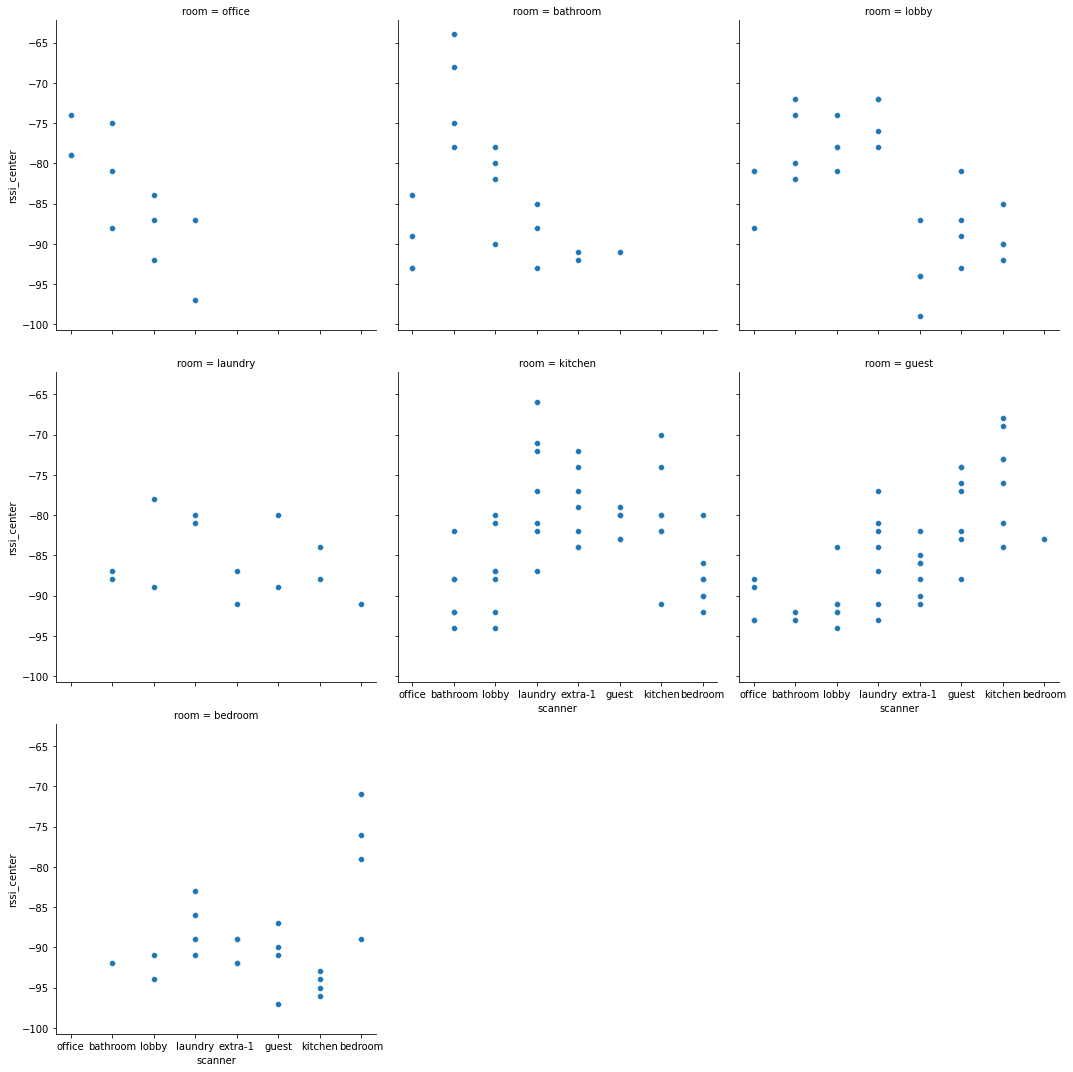

In [72]:
sbs.relplot(data=results_df, x='scanner', y='rssi_center', col='room', kind="scatter", col_wrap=3)

<AxesSubplot:xlabel='scanner', ylabel='rssi_center'>

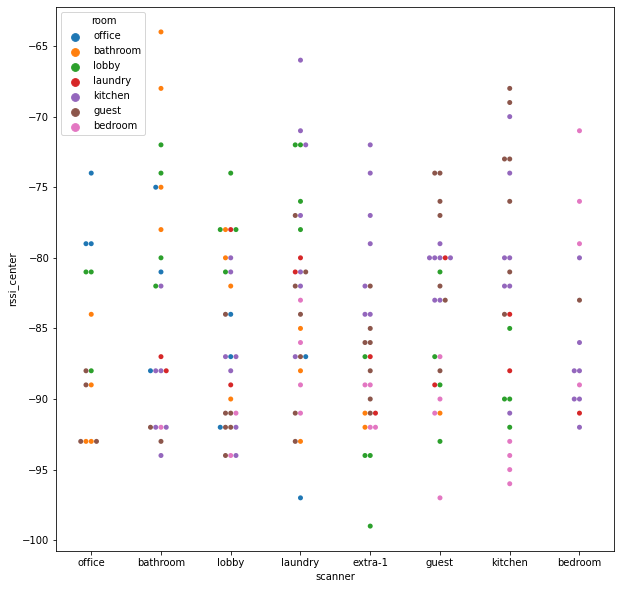

In [73]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sbs.swarmplot(data=results_df, x='scanner', y='rssi_center', hue='room', ax=ax)

Из данных графиков видно, что для каждого помещения прослеживается свой уникальный паттерн. При этом паттерны пересекаются. Из этого следует, что искомый алгоритм классификации должен определять положение устройства в каждом помещении отдельно, чтобы иметь возможность одновременно позиционировать устройство в нескольких помещениящ, ввиду того, что могут быть пересечения (устройство можно отнести более чем к одному помещению, если сравнивать с имеющимися данными).

__Предположение:__ для фиксированного сканера и фиксированного положения устройства найденные средние уровни сигналов определяют разброс возможных значений. Таким образом искомый алгоритм классификации должен быть обучен в том числе на промежуточных значениях между минимумом и максимумом, так алгоритм получится более генерализованным.

# Наивный алгоритм
Исходя из сделанных выше предположений есть идея наивного алгоритма: имея интервалы возможных значений сигнала для каждого сканера в каждом помещении, найти те интервалы, в которые попадают текущие значения со сканеров. Отсортировать помещения по убыванию количества совпадений с интервалами. Взять помещения со 100% совпадением и считать их включенными. Если таковых нет – считать включенными первые два помещения по количеству совпадений. Если совпадений нет вовсе – считать все помещения выключенными. 

Реализуем этот алгоритм и изучим метрики качества. Нам больше всего нехочется иметь ложно отрицательные результаты (человек в помещении и свет выключился), ложно положительные значения тоже хотелось бы свести к разумному минимум

In [74]:
singal_ranges_df = results_df.groupby(['room', 'scanner']).agg(min=('rssi_center', 'min'), max=('rssi_center', 'max'))
sorted_scanners = sorted(results_df['scanner'].unique())
sorted_rooms = sorted(results_df['room'].unique())

In [75]:
def naive_predict_presence(X):
    signals_df = pd.DataFrame({
        'room':  [rr for r in sorted_rooms for rr in ([r] * len(sorted_scanners))],
        'scanner': sorted_scanners * len(sorted_rooms), 
        'rssi': X * len(sorted_rooms)
    }).set_index(['room', 'scanner'])
    local_ranges_df = singal_ranges_df.copy()
    local_ranges_df['min_diff'] = local_ranges_df['min'] - signals_df['rssi']
    local_ranges_df['max_diff'] = local_ranges_df['max'] - signals_df['rssi']
    local_ranges_df['in_range'] = False
    local_ranges_df.loc[(local_ranges_df['min_diff'] <= 0) & (local_ranges_df['max_diff'] >= 0), 'in_range'] = True
    local_ranges_df['abs_min_diff'] = local_ranges_df[['min_diff', 'max_diff']].abs().min(axis=1)
    local_ranges_df.loc[(local_ranges_df['in_range'] == True), 'abs_min_diff'] = 0
    rooms_perf_df = local_ranges_df.groupby(['room']).agg(
        error_sum=('abs_min_diff', 'sum'), 
        error_mean=('abs_min_diff', 'mean'),
        low_error_scanners=('abs_min_diff', lambda x: sum(x < 5)),
    ).sort_values('error_sum')

    if sum(local_ranges_df['in_range'] == True) == 0:
        return [], rooms_perf_df

    # if rooms_perf_df.iloc[0]['error_sum'] == 0:
    #     return list(rooms_perf_df[rooms_perf_df['error_sum'] == 0].index), rooms_perf_df

    prediction = [rooms_perf_df.iloc[0].name]

    # if rooms_perf_df.iloc[1]['error_sum'] <= 25:
    #     prediction.append(rooms_perf_df.iloc[1].name)

    return prediction, rooms_perf_df

naive_predict_presence([-100]*len(sorted_scanners))

([],
           error_sum  error_mean  low_error_scanners
 room                                               
 office         44.0   11.000000                   1
 bedroom        49.0    7.000000                   2
 bathroom       63.0   10.500000                   0
 kitchen        75.0   10.714286                   0
 guest          81.0   10.125000                   0
 laundry        83.0   11.857143                   0
 lobby          87.0   12.428571                   1)

### Генерация правдоподобных данных
Чтобы измерять качество алгоритма нужны данные, на которых будет производиться измерение. Чем ближе данные будут к реальным тем лучше. Данные, собранные выше, нельзя назвать естественным и близкими к реальности, так как браслет лежал по 20 минут неподвижно. Эти данные больше подходят для анализа статистических характеристик метода измерения. Но из них можно попробовать построить более реалистичные данные эмитирую перемещение браслета из позиции в позицию, из комнаты в комнату.

In [163]:
session_dur_df = data_df.groupby(['room', 'position']).agg(when_min=('when', 'min'), when_max=('when', 'max'), signals=('when', 'count'))
session_dur_df['when_diff'] = np.round((session_dur_df['when_max'] - session_dur_df['when_min']) / np.timedelta64(1, 's'))
session_dur_df['frequency'] = session_dur_df['signals'] / session_dur_df['when_diff']

penalizing laundry


In [183]:
PENALIZE_SECONDS = 15
PENALTY_AMOUNT = 2
KALMAN_Q = 10
KALMAN_R = 0.15

def generate_data(circles=10, data_size=None):
    filters = dict([(s, KalmanRSSI(R=KALMAN_R, Q=KALMAN_Q)) for s in sorted_scanners])
    signals_history = dict([(s, 0) for s in sorted_scanners])
    used_data_df = data_df
    X = []
    y = []

    if data_size and data_size > 0:
        used_data_df = []
        for room in sorted_rooms:
            room_df = data_df[(data_df['room'] == room)]
            used_data_df.append(room_df.sample(min(data_size, len(room_df))))
        used_data_df = pd.concat(used_data_df)
    
        print('Original signals {}, selected signals {}'.format(len(data_df), len(used_data_df)))
        print(used_data_df.groupby(['room']).agg(signals=('rssi', 'count')))

    for _ in range(circles):
        for room in np.random.choice(sorted_rooms, len(sorted_rooms), replace=False):
            room_init = False
            seconds_passed = 0
            positions = used_data_df[used_data_df['room'] == room]['position'].unique()
            for _ in range(3):
                for position in np.random.choice(positions, len(positions), replace=False):
                    signals_per_sec = session_dur_df.loc[(room, position), 'frequency']
                    signals = used_data_df[(used_data_df['room'] == room) & (used_data_df['position'] == position)]
                    signals = signals.sample(len(signals))
                    
                    for _, row in signals.iterrows():
                        seconds_passed += 1 / signals_per_sec
                        signals_history[row['scanner']] = 0
                        filters[row['scanner']].filter(row['rssi'])
                        data_row = [filters[s].lastMeasurement() or -100 for s in sorted_scanners]

                        for s in sorted_scanners:
                            signals_history[s] += 1
                            if signals_history[s] > (PENALIZE_SECONDS / signals_per_sec):
                                signals_history[s] = 0
                                filters[s].filter(-100)

                        if room_init:
                            X.append(data_row)
                            y.append(room)
                        elif seconds_passed > 120:
                            room_init = True
    return X, y

X, y = generate_data(1)

Алгоритм выше эмитирует N проходов по квартире по всем комнатам в случайном порядке в каждый проход. В каждой комнате совершается два круга по всем известным положениям, при этом первые полторы минуты в каждой комнате не учитываются, так как датчик движения ждет 2 минуты после последнего зарегистрированного движения, поэтому ошибочное определения положения в первые полторы минуты некритично так как не приведет к отключению света. В каждом положении эмитируется 6 минту прибывания устройства путем случайного выбора M сигналов из известных в данном положении. Каждый сигнал пропускается через фильтр Калмана. Для каждого сигнала берется срез текущих значений со сканеров из фильтров Калмана, этот срез и является элементом обучающей выборки. 

### Проверим работу наивного алгоритма

In [184]:
# y_pred = [naive_predict_presence(x) for x in X]
# y_pred, y_errors = ([i for i, _ in y_pred], [j for _, j in y_pred])

In [185]:
# correct_pred = sum([v in y_pred[i] for i, v in enumerate(y)])
# precision = correct_pred / len(y)
# print('Correctly identified {} out of {}, precision {}'.format(correct_pred, len(y), precision))

Хороший результат! Точность в 98% вполне достаточно. Это не 100%, конечно, иногда свет будет выключаться, но очень редко. Но хочется понять что стоит за этим результатом и есть ли шанс достичь 100%. Конечно это все лишь результат на собранных данных, в реальности ошибок может быть больше.

Изучим на каком месте по ошибках находится верный результат, на каком – ошибочный, какова средняя ошибка верного результата и какую ошибку имеет второе предсказанное "запасное" помещение.

In [186]:
# pred_res_df = pd.DataFrame([{
#     'correct': v in y_pred[i],
#     'predicted_rooms': len(y_pred[i]),
#     'actual_room': v,
#     'signal_error': y_errors[i].loc[v, 'error_sum'],
#     'signal_error_mean': y_errors[i].loc[v, 'error_mean'],
#     'signal_position': y_errors[i].index.get_loc(v),
#     'error_0': y_errors[i].iloc[0]['error_sum'],
#     'error_1': y_errors[i].iloc[1]['error_sum'],
#     'error_2': y_errors[i].iloc[2]['error_sum'],
# } for i, v in enumerate(y)])

In [187]:
# precision_df = pred_res_df.groupby(['actual_room']).agg(correct=('correct', 'sum'), all=('correct', 'count'))
# precision_df['precision'] = precision_df['correct'] / precision_df['all']
# precision_df

In [188]:
# fig = sbs.displot(data=pred_res_df[(pred_res_df['correct'] == True)], x='predicted_rooms').figure

penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office


In [189]:
# fig = sbs.displot(data=pred_res_df[pred_res_df['signal_position'].isin([0, 1])], x='error_1', hue='signal_position', col='actual_room', col_wrap=3).figure

Из графиков распределения выше видно, что в случае, когда правильная комната расположена на второй позиции по сумме ошибки, не представляется возможным отделить этот вариант путем отсечения некоторым значением суммарной ошибки без добавления большого количества true-negatives. Возможно существует лучшая метрика для отсечения?

## Другие простые алгоритмы

In [190]:
X, y = generate_data(5)
# X_test, y_test = generate_data(3)
X_train, X_test, y_train, y_test = model_selection.train_test_split(np.array(X), np.array(y), stratify=y, random_state=42, test_size=0.2)
print('Training {}, testing {}'.format(str(len(y_train)), str(len(y_test))))

Training 15660, testing 3915


In [191]:
# pd.DataFrame([dict(list(zip(sorted_scanners, x))) for x in X_train])

In [192]:
def evaluate_estimator(estimator):
    pred_probas = estimator.predict_proba(X_test)
    pred_probas_df = pd.DataFrame([dict(list(zip(sorted_rooms, r)) + [('_room', y_test[i])]) for i, r in enumerate(pred_probas)])
    fix, axes = plt.subplots(1, len(sorted_rooms), figsize=(25, 5))
    for i, room in enumerate(sorted_rooms):
        sbs.scatterplot(data=pred_probas_df, x='_room', y=room, ax=axes[i])
        axes[i].set_title(room)

In [193]:
scoring = {
    # 'auc_roc': metrics.make_scorer(metrics.roc_auc_score, average = 'macro', multi_class='ovr'),
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision': metrics.make_scorer(metrics.precision_score, average = 'macro'),
    'recall': metrics.make_scorer(metrics.recall_score, average = 'macro'),
    'f1_macro': metrics.make_scorer(metrics.f1_score, average = 'macro'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average = 'weighted')
}

kn_estimator = multiclass.OneVsRestClassifier(KNeighborsClassifier())
model_selection.cross_validate(kn_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([0.07167697, 0.07096028, 0.07177448]),
 'score_time': array([0.46265578, 0.4696269 , 0.47356415]),
 'test_accuracy': array([1., 1., 1.]),
 'test_precision': array([1., 1., 1.]),
 'test_recall': array([1., 1., 1.]),
 'test_f1_macro': array([1., 1., 1.]),
 'test_f1_weighted': array([1., 1., 1.])}

              precision    recall  f1-score   support

    bathroom       1.00      1.00      1.00       656
     bedroom       1.00      1.00      1.00       615
       guest       1.00      1.00      1.00       832
     kitchen       1.00      1.00      1.00       803
     laundry       1.00      1.00      1.00       249
       lobby       1.00      1.00      1.00       439
      office       1.00      1.00      1.00       321

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915



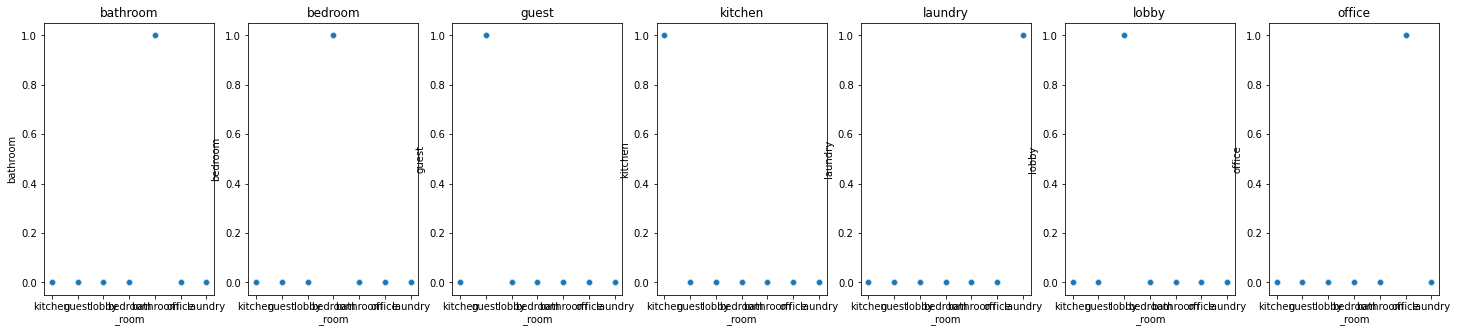

In [194]:
kn_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, kn_estimator.predict(X_test)))
evaluate_estimator(kn_estimator)

In [195]:
xgb_estimator = multiclass.OneVsRestClassifier(RandomForestClassifier(n_estimators=5, class_weight='balanced', n_jobs=-1))
model_selection.cross_validate(xgb_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([2.29937005, 0.12408638, 0.12281299]),
 'score_time': array([0.07771158, 0.07780457, 0.07640457]),
 'test_accuracy': array([1., 1., 1.]),
 'test_precision': array([1., 1., 1.]),
 'test_recall': array([1., 1., 1.]),
 'test_f1_macro': array([1., 1., 1.]),
 'test_f1_weighted': array([1., 1., 1.])}

              precision    recall  f1-score   support

    bathroom       1.00      1.00      1.00       656
     bedroom       1.00      1.00      1.00       615
       guest       1.00      1.00      1.00       832
     kitchen       1.00      1.00      1.00       803
     laundry       1.00      1.00      1.00       249
       lobby       1.00      1.00      1.00       439
      office       1.00      1.00      1.00       321

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915



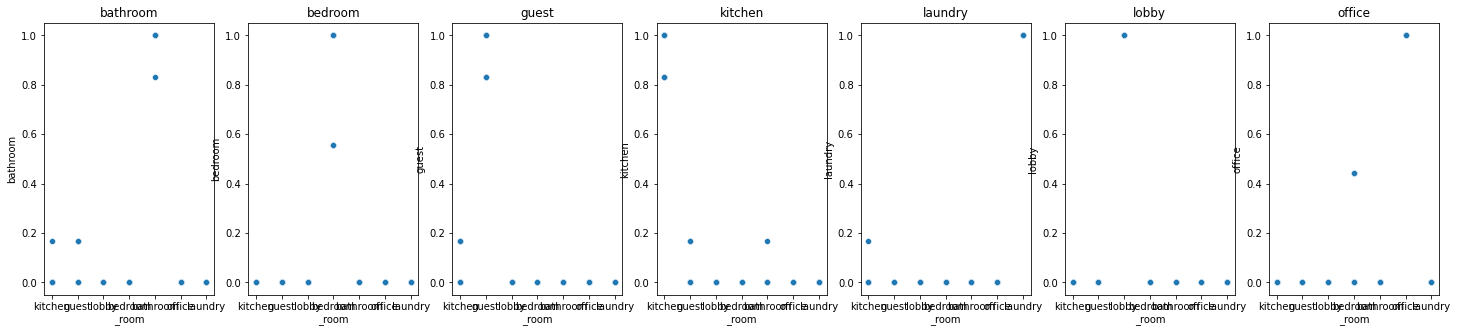

In [196]:
xgb_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, xgb_estimator.predict(X_test)))
evaluate_estimator(xgb_estimator)

In [197]:
linear_estimator = multiclass.OneVsRestClassifier(linear_model.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.001, max_iter=10000))
model_selection.cross_validate(linear_estimator, X_train, y_train, cv=3, scoring=scoring)

{'fit_time': array([6.5913825 , 7.78440046, 7.5113163 ]),
 'score_time': array([0.05863214, 0.05226231, 0.05845428]),
 'test_accuracy': array([0.97911877, 0.98409962, 0.98333333]),
 'test_precision': array([0.97043747, 0.97760395, 0.97667958]),
 'test_recall': array([0.97278653, 0.9809014 , 0.98220206]),
 'test_f1_macro': array([0.97149877, 0.97916086, 0.97930923]),
 'test_f1_weighted': array([0.97923393, 0.98418156, 0.98345057])}

              precision    recall  f1-score   support

    bathroom       1.00      0.98      0.99       656
     bedroom       1.00      1.00      1.00       615
       guest       1.00      1.00      1.00       832
     kitchen       0.99      0.98      0.98       803
     laundry       0.94      0.94      0.94       249
       lobby       0.96      0.99      0.98       439
      office       0.99      1.00      1.00       321

    accuracy                           0.99      3915
   macro avg       0.98      0.98      0.98      3915
weighted avg       0.99      0.99      0.99      3915



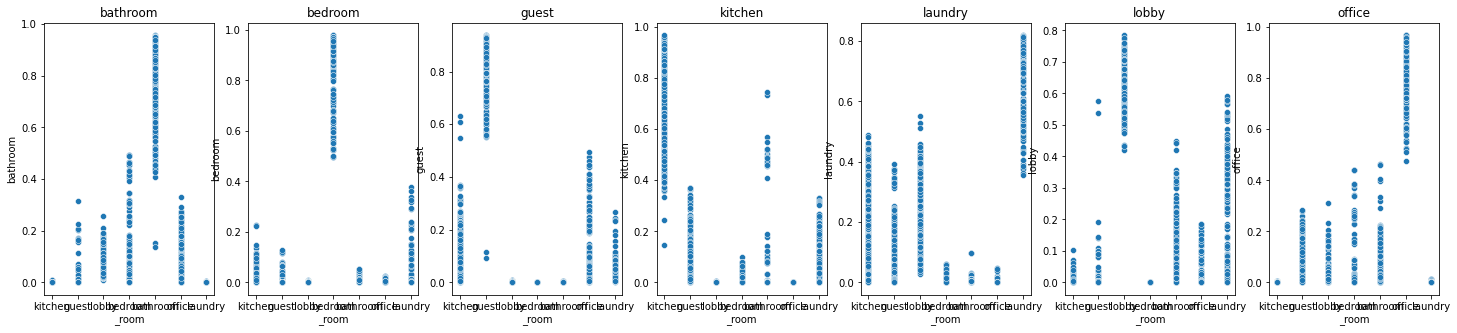

In [198]:
linear_estimator.fit(X_train, y_train)
print(metrics.classification_report(y_test, linear_estimator.predict(X_test)))
evaluate_estimator(linear_estimator)

По объективным метрикам все классические алгоритмы работают лучше наивного алгоритма. Неизместно лишь то насколько они хорошо генерализованы.

## Выбор порога
Важнее всего, чтобы свет не выключался когда в помещении кто-то есть, если свет будет гореть чуть дольше там, где никого нет, не так уж и страшно. Иными словами важнее recall чем precision. Исходя из этого нужно выбрать пороги когда считать каждое из помещений активным.

In [199]:
pred_probas = linear_estimator.predict_proba(X_test)
pred_probas_df = pd.DataFrame([dict(list(zip(sorted_rooms, r)) + [('_room', y_test[i])]) for i, r in enumerate(pred_probas)])
room_thresholds = {}
beta = 1000 # recall is more important than precision
for i, room in enumerate(sorted_rooms):
    y_true = [1 if x else 0 for x in pred_probas_df['_room'] == room]
    y_pred = list(pred_probas_df[room])
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    beta_squared = beta ** 2
    fscore = ((1 + beta_squared) * precision * recall) / (beta_squared * precision + recall)
    ix = np.argmax(fscore)
    room_thresholds[room] = thresholds[ix]
    print('%s - Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (room, thresholds[ix], fscore[ix], precision[ix], recall[ix]))

bathroom - Best Threshold=0.138631, F-Score=1.000, Precision=0.825, Recall=1.000
bedroom - Best Threshold=0.496800, F-Score=1.000, Precision=1.000, Recall=1.000
guest - Best Threshold=0.094575, F-Score=1.000, Precision=0.720, Recall=1.000
kitchen - Best Threshold=0.145786, F-Score=1.000, Precision=0.804, Recall=1.000
laundry - Best Threshold=0.355284, F-Score=1.000, Precision=0.557, Recall=1.000
lobby - Best Threshold=0.419126, F-Score=1.000, Precision=0.918, Recall=1.000
office - Best Threshold=0.476098, F-Score=1.000, Precision=1.000, Recall=1.000


## Проверка боем

Выше были построены различные модели и вычислина их точность. Теперь нужно проверить насколько хорошо они работают на практике.

In [200]:
async def real_world_prediction(predictor):
    filters = dict([(s, KalmanRSSI(R=KALMAN_R, Q=KALMAN_Q)) for s in sorted_scanners])
    scanner_history = dict([(s, 0) for s in sorted_scanners])

    async def penalize_filters():
        while(True):
            await asyncio.sleep(1)
            for s in sorted_scanners:
                scanner_history[s] += 1
                if scanner_history[s] > PENALIZE_SECONDS:
                    print('penalizing {}'.format(s))
                    filters[s].filter(-100)
                    scanner_history[s] = 0
            
    async def run_scanning(): 
        async with Client(
            hostname=config.MQTT_BROKER_URL, port=config.MQTT_BROKER_PORT,
            username=config.MQTT_USERNAME, password=config.MQTT_PASSWORD) as client:
            async with client.unfiltered_messages() as messages:
                await client.subscribe("room_presence/#")
                async for message in messages:
                    event = jsons.loads(message.payload.decode())
                    if event['id'] != 'eb:cd:02:7f:98:91'.upper():
                        continue

                    scanner = message.topic.split('/')[1]
                    filters[scanner].filter(event['rssi'])
                    scanner_history[scanner] = 0
                    data_row = [filters[s].lastMeasurement() or -100 for s in sorted_scanners]

                    pred_result = list(zip(kn_estimator.classes_, predictor.predict_proba(np.array([data_row]))[0]))
                    max_pred_result = max(pred_result, key=lambda x: x[1])
                    pred_result = [r for r in pred_result if r[1] >= room_thresholds[r[0]]]
                    pred_result = [max_pred_result] if not pred_result else pred_result
                    print(pred_result, scanner, event['rssi'])

    await asyncio.gather(
        asyncio.create_task(penalize_filters()),
        asyncio.create_task(run_scanning())
    )

In [201]:
await real_world_prediction(linear_estimator)

[('kitchen', 0.5056379354716394)] extra-1 -88
[('guest', 0.7137656311947668), ('kitchen', 0.18546502951163552)] kitchen -78
[('guest', 0.715759932251113), ('kitchen', 0.18598322916724405)] guest -87
[('guest', 0.7161138128406169), ('kitchen', 0.18576734826921606)] kitchen -75
penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office
[('guest', 0.7161138128406169), ('kitchen', 0.18576734826921606)] guest -87
[('guest', 0.35831889775870257), ('kitchen', 0.22429175465738346), ('laundry', 0.3605480988746855)] laundry -70
[('guest', 0.2772677206655408), ('kitchen', 0.17355730877417003)] lobby -81
[('guest', 0.27729369448248525), ('kitchen', 0.17357356723280581)] guest -80
[('guest', 0.2753237508039616), ('kitchen', 0.1758239625539859)] laundry -68
[('guest', 0.26636515083686463), ('kitchen', 0.20204033274129174)] extra-1 -86
[('guest', 0.2663552995873767), ('kitchen', 0.20203286048105726)] guest -89
[(

CancelledError: 

penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office
penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office
penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office
penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office
penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office
penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry
penalizing lobby
penalizing office
penalizing bedroom
penalizing bathroom
penalizing extra-1
penalizing guest
penalizing kitchen
penalizing laundry

## Оптимальный объем выборки
Сбор 100 сигналов на 2 сканера в одном положении занимал от 10 до 20 минут. Хочется сократить это время и понять какой минимум времени нужно ждать, чтобы получить те же средние значения что и в полной выборке. Это можно сделать аналитически и численно. Аналитически путем анализа распределения и задания доверительных интервалов для некоторой точности. Численно путем оптимизации некоторой функции потерь, которая будет равна 1 при 10 сигналах со сканера и в точности совпадающему среднему с средним по всей доступной выборке, равна 0 если объем выборки равен всей доступной выборке.

## Поведение Калмана

Нужно изучить как себя ведет фильтр Калмана при разных параметрах, чтобы определиться с оптимальными значениями.

In [ ]:
kalman_scanner = 'laundry'
kalman_means = results_df[(results_df['scanner'] == kalman_scanner)].groupby(['scanner', 'room', 'position']).agg(rssi_mean=('rssi_center', 'mean'))

In [ ]:
test_filters = [
    KalmanRSSI(R=0.08, Q=10),
    KalmanRSSI(R=0.08, Q=20),
    KalmanRSSI(R=0.08, Q=30),
    KalmanRSSI(R=0.08, Q=50),
]
filtered_values = []
counter = 0
for (scanner, room, position), r in kalman_means.iterrows():
    # if position != 'lobby-1636398557.066242': continue
    slice_df = data_df[(data_df['room'] == room) & (data_df['position'] == position) & (data_df['scanner'] == scanner)]
    slice_df = slice_df.sample(len(slice_df), random_state=42)

    for _, signal in slice_df.iterrows():
        counter += 1
        filtered_values.append({
            'id': counter,
            'scanner': scanner,
            'room': room,
            'position': position,
            'rssi': r['rssi_mean'],
            'params': 'Actual Mean',
        })
        filtered_values.append({
            'id': counter,
            'scanner': scanner,
            'room': room,
            'position': position,
            'rssi': signal['rssi'],
            'params': 'Raw RSSI',
        })
        for fl in test_filters:
            filtered_values.append({
                'id': counter,
                'scanner': scanner,
                'room': room,
                'position': position,
                'rssi': fl.filter(signal['rssi']),
                'params': 'R={};Q={}'.format(str(fl.R), str(fl.Q)),
            })
    
filtered_values = pd.DataFrame(filtered_values)

<AxesSubplot:xlabel='id', ylabel='rssi'>

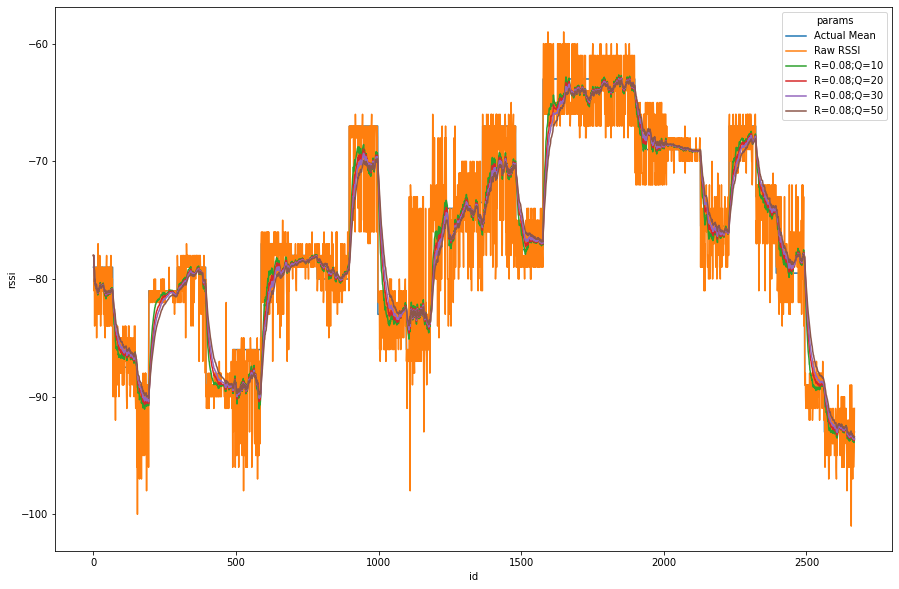

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
sbs.lineplot(data=filtered_values, x='id', y='rssi', hue='params', ax=axes)

Параметры Q и R влияют на скорость схождения к некоторому среднему. Из проверенных параметров R=0.08 и Q=10 выглядит как хорошей комбинацией, сходимость наступает быстрее других вариантов, при этом волатильность не увиличивается значительно.